# Feature Extraction - Retailers Classification

In [1]:
import pandas as pd
import re 
from re import search
import spacy 
import os 
import numpy as np
import os, nltk, glob
import textdistance
import string
import altair as alt
import janitor
from sklearn.preprocessing import MultiLabelBinarizer
# Enable for jupter notebook only 
alt.renderers.enable('notebook')

RendererRegistry.enable('notebook')

In [2]:
# Display all rows width and length
pd.set_option('display.max_columns', None) 
pd.set_option('display.max_rows', None) 
pd.set_option('display.max_colwidth', None)  

### Export CSV function

In [3]:
# Write CSV function
def write_csv(df, file_name="file_name", file_path= "../../data/input/feature_extraction", out_sys = "win"):
    '''
    '''
    
    ouput_path_name = file_path+'/'+file_name
    
    if out_sys == "win":
    # For windows systems
        df.to_csv(ouput_path_name+'.csv', encoding='utf-8-sig', index=False)
    elif out_sys == "mac":
    # For mac systems
        df.to_csv(ouput_path_name+'.csv', encoding="utf-8", index=False)
    
    #print("Exported CSV file to {} \n".format(ouput_path_name+'.csv'))

    return print("Exported CSV file to {} \n".format(ouput_path_name+'.csv'))

# Method 2

This Methos was develop with Manuel since my previous method was more complicated and he wanted to get a a metric of how many more jobs were missing categorization.

## Data Load

In [4]:
# Company data
resume_info = pd.read_csv('../../data/input/feature_extraction/manual_extraction_template.csv')
# List of food_service_retailers
foodservice_df = pd.read_csv('../../data/input/feature_extraction/food_retail_list.csv')
# list of retailers
retailers_df = pd.read_csv('../../data/input/feature_extraction/retail_list.csv')
# list of food_convenience_pharmacy retailers
fcp_df = pd.read_csv('../../data/input/feature_extraction/food_convenience_pharmacy.csv')
# list of clothing_footwear retailers
clothing_footwear_df = pd.read_csv('../../data/input/feature_extraction/clothing_footwear_retailers.csv')
# list of consumer electronics retailers
consumer_electronics_df = pd.read_csv('../../data/input/feature_extraction/consumer_electronics_retailers.csv')
# Company Sector Master List
master_list = pd.read_csv('../../data/input/feature_extraction/master_list_sectors2.csv')

# List was uploaded directly into Notebook
# list of Car Dealers
#auto_dealers_df = pd.read_csv('../../data/input/feature_extraction/auto_dealers.csv')

In [5]:
manual_extraction = resume_info.copy()

list_company = list()
for n in range(7):
    #myDict_in = dict()
    for t in list(['company']):
        col_name = "work"+str(n+1)+"_"+t
        current_col = manual_extraction[col_name]
        for i in current_col:
            if len(str(i))<2 or str(i)=="nan":
                continue
                i = "unknown"
            if t == 'company':
                list_company.append(i)

In [6]:
def clean_txt_f(txt):
    txt = str(txt)
    punct_list = list(string.punctuation+"·"+"−"+"§"+"•"+"–"+"––"+"✓")
    punct_list.remove("&")
    exclude = set(punct_list)
    clean_txt = "".join([i for i in txt.lower() if i not in exclude])
    clean_txt = re.sub(r'\s+', ' ', clean_txt)
    return clean_txt

In [7]:
def lookup_similar(txt,list_search):
    similarity_scores = list(map(lambda x: textdistance.levenshtein.normalized_similarity(txt,x), list_search))
    pos_max_score = similarity_scores.index(max(similarity_scores))
    max_score = similarity_scores[pos_max_score]
    matched_company = list_search[pos_max_score]
    results = list([max_score,matched_company,pos_max_score])
    return results

## Update Master List

In [8]:
master_list.rename(columns = {master_list.columns[0]:"Store"},inplace = True)
master_list.rename(columns = {master_list.columns[1]:"Sector"},inplace = True)
master_list = master_list.dropna()

In [9]:
master_list.head(1)

,Store,Sector
0,A Buck or Two,Specialty retailers


## Generate plot with Master list for Report (Optional)

In [10]:
def category_plot(df, col_name='category'):
    '''
    '''
    
    s = df[col_name].value_counts() 
    freq = pd.DataFrame({col_name:s.index, 'Count':s.values}) 
    
    plot = alt.Chart(freq).transform_joinaggregate(
    Total='sum(Count)',
    ).transform_calculate(
        Percentage="datum.Count / datum.Total"
    ).mark_bar().encode(
        alt.X('Percentage:Q', axis=alt.Axis(format='.0%')),
        y=str(col_name)+':N'
    )
    
    return plot

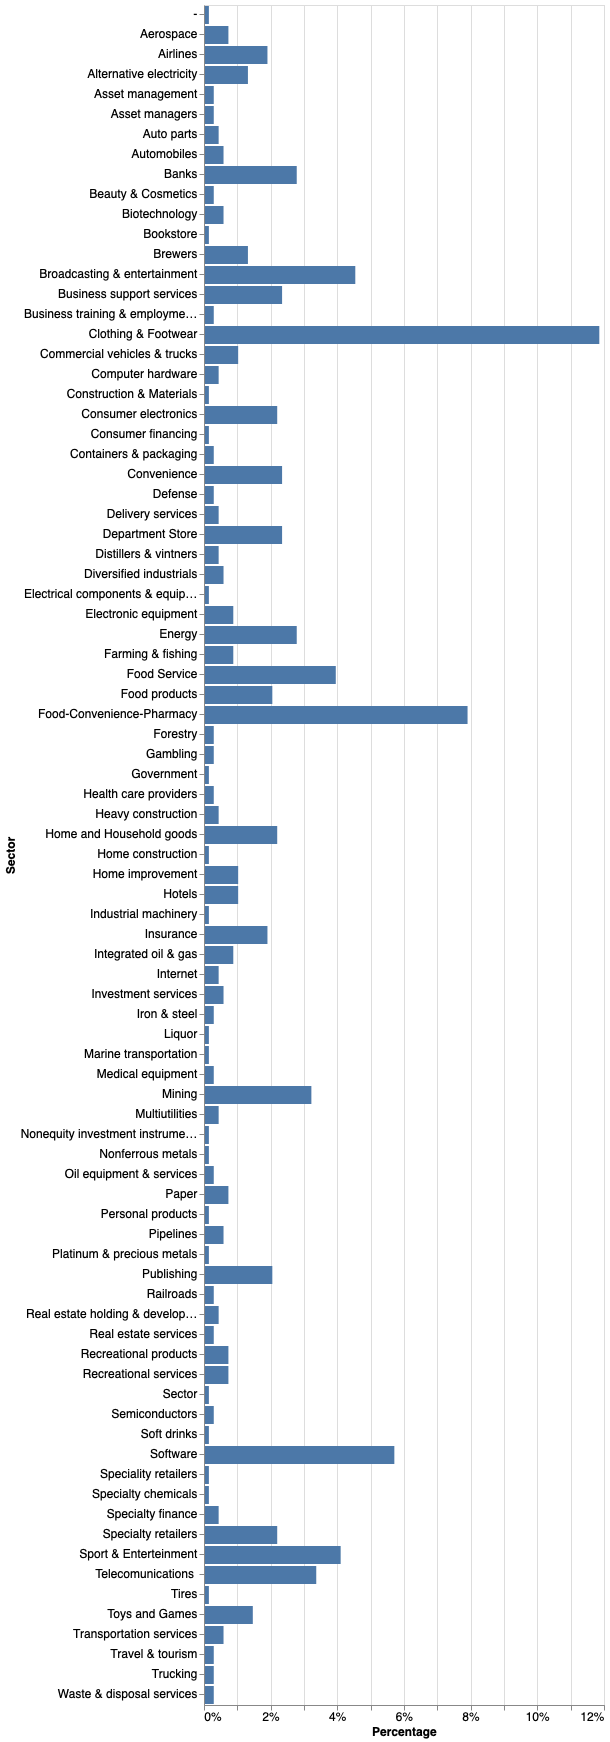

In [11]:
category_plot(master_list, col_name ='Sector')

## Increase Master list with additional data

In [12]:
# Edit data frames names and columns to join them with Master list data frame

store_col_name = 'Store'
sector_col_name = 'Sector'

foodservice_df[sector_col_name] = 'Food Service'
foodservice_df.rename(columns = {foodservice_df.columns[0]:store_col_name},inplace = True)

fcp_df[sector_col_name] = 'Food-Convenience-Pharmacy'
fcp_df.rename(columns = {fcp_df.columns[0]:store_col_name},inplace = True)

clothing_footwear_df[sector_col_name] = 'Clothing & Footwear'
clothing_footwear_df.rename(columns = {clothing_footwear_df.columns[0]:store_col_name},inplace = True)

consumer_electronics_df[sector_col_name] = 'Consumer electronics'
consumer_electronics_df.rename(columns = {consumer_electronics_df.columns[0]:store_col_name},inplace = True)

# Cars are imported Manually will live this in case we want to have a list outside

#auto_dealers_df[sector_col_name] = 'Car dealership'
#auto_dealers_df.rename(columns = {auto_dealers_df.columns[0]:company_col_name},inplace = True)

# Concatenate all lists into the master list
master_list_2 = pd.concat([master_list, foodservice_df, fcp_df, clothing_footwear_df, consumer_electronics_df]).reset_index()

## Remove Duplicates from Master List

### Note: 
#### dropna() was not working properly so I made a function using dictionary to remove duplicates

In [13]:
def prepare_master_list(df, entity_name ='Store', sector_name ='Sector'):
    '''
    '''
    
# Remove empty lines
    df = df.dropna(subset=[entity_name])
    
# Remove duplicates and Sort df
#     df = df.drop_duplicates(subset=None, keep='first', inplace=False)
#     df = df.sort_values(by=[entity_name], ascending=True)
    
# Remove duplicates (redundacy) and sort using dictionary function if pandas remove duplicate does not work for unknown reasons
    company_sector_dict = pd.Series(df[sector_name].values, index=df[entity_name]).to_dict()
    df_dic = {}
    for k,v in company_sector_dict.items():
        df_dic.setdefault(entity_name,[]).append(k)
        df_dic.setdefault(sector_name,[]).append(v)
    df = pd.DataFrame(df_dic)
    
# Reset_Index
    df = df.reset_index().drop('index',1)
# Rename df columns
    #df = df.rename({entity_name:'entity', sector_name:'category'}, axis=1)
    
    return df 

In [14]:
# Apply above function to remove duplicates
master_list_2 = prepare_master_list(master_list_2, entity_name ='Store', sector_name ='Sector')

<!-- ## Edit Categories Manually (Expert Advice) -->

In [15]:
# # Draft, add list of companies per sector or dictionary form to avoid repetition

# def edit_sector(master_list):
#     '''
#     '''  
#     if master_list['Store']=='Walmart':
#         label = "Telecomuncations "
#     if master_list['Store']=='Best Buy':
#         label = "Telecomuncations "
#     else:
#         label = master_list['Sector']
#     return label   

In [16]:
# master_list_2['Sector'] = master_list_2.apply(lambda x : edit_sector(x),axis =1)

## Plot Distribution new Distribution of categories for the report (Optional)

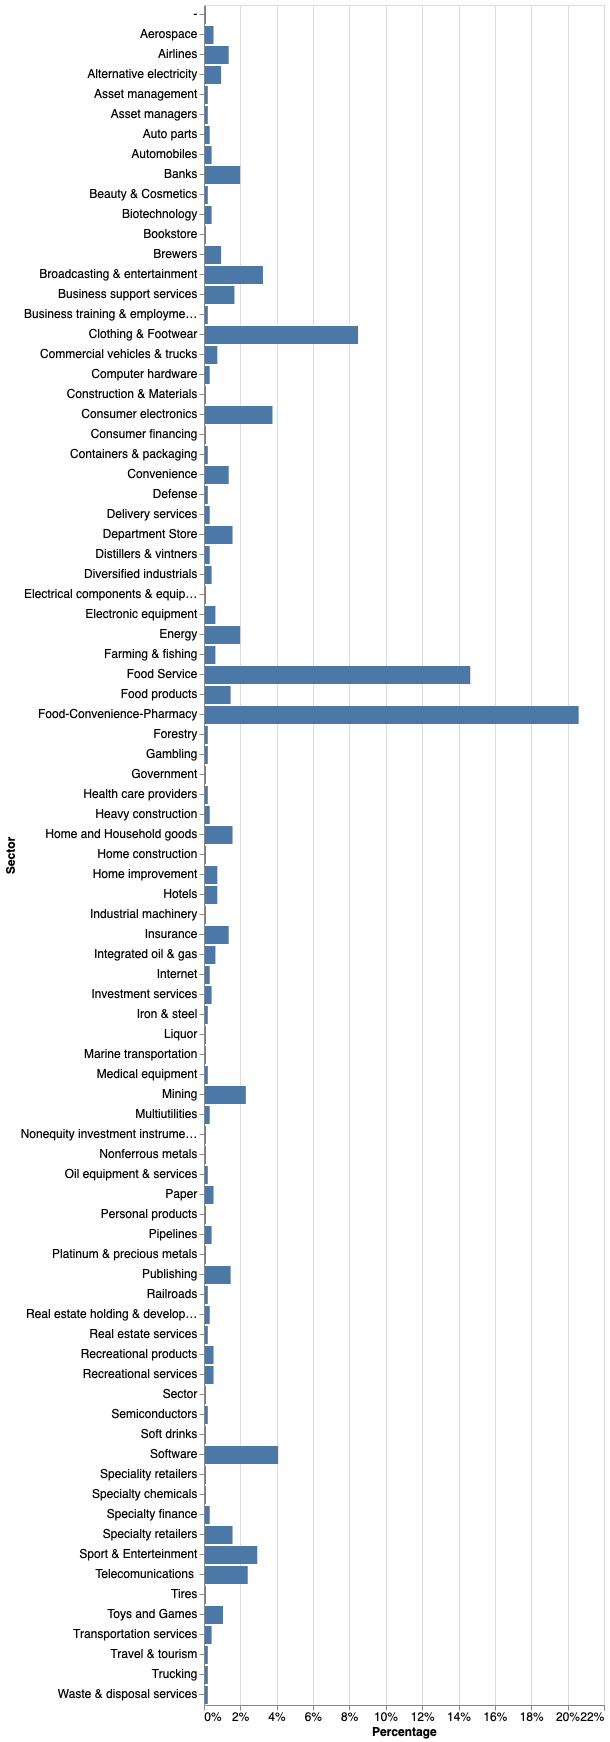

In [17]:
# Plot Distribution new Distribution of categories for the report optional
category_plot(master_list_2, col_name ='Sector')

## Clean Master List  Names & Generate Store and Sector List

In [18]:
# Clean Master List
master_list['clean_store_name'] = master_list.Store.apply(lambda x: clean_txt_f(x))
master_list_2['clean_store_name'] = master_list_2.Store.apply(lambda x: clean_txt_f(x))

In [19]:
store_list = master_list['clean_store_name']
store_sector = master_list['Sector']

## Generate Keywords List and Dictionary

In [20]:
# 1 Mobile Competitor
mobile_user = ["freedom", "koodo", "shaw", "telus", "bell", "rogers", "the mobile shop", "best buy", "bestbuy" 
               "videotron", "wow", "mobile", "the source", "walmart", "glentel", "fido",
               'vidéotron', 'multi carrier dealer']

kw_mobile = ["cellular", "wireless", "fone", "phone"]

kw_mob = mobile_user + kw_mobile

# Food Services (Restaurants and Fastfood)
kw_food = ["restaurant","pizza", "steak", "burger", "grill", "dry bar", "coffee", "donald", "taco", 
            "catering", "burrito", "snack", "cafe", "pretzels", "mexican", "sweet", "coffee shop",
            "cuisine", "cafeteria", "chocolat", "chicken", "hard rock", "pita",'subs', 'popeyes']

fs_user = ['a & w', 'a&w', 'chuck e. cheese', 'wendy', "wendy's", 'touchdown willies', 
           "touchdown willy's tap & grill", 'tony roma’s fallsview', 'tony roma’s', "denny's", 
           'denneys', 'hard rock cafe', 'hard rock café', 'pickle barrel', 'hummingbird pub', 
           'starbucks', 'the london club', 'the nutty chocolatier', 'wild wings', 'forrat’s lounge', 
           'costa blanca', 'harveys & swiss chalet', "tucker's market place", 'bier markt', 
           'blco foods',"freshly squeezed", "tim hortons", 'subway','chuck e cheese', 'moose jaw snow hut',
           'jack astor’s', 'wood35', 'the keg', 'earl', 'taco bell']

kw_food_service =  kw_food + fs_user

# Food Retailers+Convenience Stores+Pharmacy (fcp)

# Quick Service =  Fast-food here in Canada
gas_station_retail = ['shell', 'esso', 'petro canada', 'canadian tire', 'husky market', 'chevron gas station' ]

kw_fcp1 = ['market', 'food' , 'drug', "wholesale", 'whole sale' "walmart", "loblaw", "target", "pharma",
           'dollar store']
#maybe => store

kw_fcp = gas_station_retail + kw_fcp1

kw_fretailer_convenience_pharmacy = kw_fcp

fcp_user = ['walmart supercentre', 'walmart canada corp', 'walmart super center', 'walmart', 'ancaster walmart supercentre', 
            'aisle 24', 'avondale stores', 'circke k', 'couche-tard', 'provi-soir', 'hasty market', 'irving blue canoe', 
            'irving mainway', 'needs convenience', 'olco', 'on the run', 'pioneer', 'quickie convenience stores', '7eleven', 
            "becker's", "mac's convenience stores", 'dollarama', 'mac’s convenience store calgary'
           "loblaw superstore",'convenience', 'tesco stores', 'safeway', 'costco', "tri mart express"]

# Consumer Electronics
kw_celec = ['computer', 'cellular', "mobile", "fone", "phone", "wear", "electronic",'samsung', 'amazon',
            'virgin media', 'electronic boutique']

celec_user = ["sony", "pc world", "dyson", "walmart", "fido", "teleco", "futureshop", 'future shop', 'iworld connect']

kw_consumer_electronics = kw_celec + celec_user

# Car Dealerships
kw_auto = ['saab', 'lamborghini', 'buick', 'nissan', 'jeep', 'ram', 'jaguar', 'scion', 'citroen', 'shelby', 'land rover', 
           'infiniti', 'general motors', 'bentley', 'mini', 'gmc', 'lynk co', 'rolls-royce', 'panoz', 'ferrari', 
           'chevrolet', 'lincoln', 'mazda', 'srt', 'dodge', 'alfa romeo', 'mclaren', 'car sales', 'fisker', 
           'fiat', 'cadillac', 'suzuki', 'karma', 'bugatti', 'lexus', 'tesla', 'ford', 'pontiac',
           'acura', 'hyundai', 'bmw', 'qoros', 'volvo', 'volkswagen', 'aston martin', 'chrysler', 'maserati',
           'polestar', 'porsche', 'lotus', 'mercedes–benz', 'honda', 'subaru', 'detroit electric', 'kia', 'toyota', 
           'dealership', 'mitsubishi', 'mg','automotive', 'mercedesbenz', 'go auto','canada drives', 'beta auto',
           'quality cars', 'cars', 'honda']

#auto_user = ['smart','audi']

kw_car_dealers = kw_auto

# Blue Colar (Manual Labor)
kw_bcolar = ["plumb", "restoration", "repair", "land scaping", "concrete", "finishing", "mansory", "lawn", "roof", 
             "mason", "landscaping", "ground-keeping", "installation", "carpent", "lawncare", "cleaning", 
             "home improvement", "public transit", "pool clean", "mantain", "moving co", 'movers',
             'movoing', 'labourer']

kw_blue_collar = kw_bcolar

# Healthcare
kw_health = ["healthcare", "therap", "transplant", "medicine", "medical", "diagnostic", 'health centre',
             'health center', "hospital", "dental", "massage", "accupunture", "orthodont", "doctor", "autism",
            'family practice', 'clinic', 'vision']

kw_healthcare = kw_health 

# Sport+Travel+Entertainment+Hoteling
kw_steh = ["club", "theater", "theatre", "sport", "goodlife", "fit", "fitness", "gym", "cine", 
            "speed", "hotel", "resort", "inn", "hilton", "howard", "holliday", "travel", 'drinksmart',
           "suites", 'karaoke', 'best western','waterpark', 'tour','hometel','lodge', 'wonderland',
          'polarpak']

steh_user = []

kw_sport_travel_entertain_hotel = kw_steh + steh_user

kw_pcem = ["consulting", "professional", "attorney", "integrated solutions", "engineering",
          'integrated staffing', 'customer solution', "business developers", 
          "industrial developement", 'solutions', 'contemporary security canada', "h&r block", 
          'tax preparation']

pcem_user = []

kw_professional_services = kw_pcem + pcem_user 

# Clothing+Footwear
kw_cfwear = ['fashion', 'footwear', "foot", "boot", "apparel", "lids", "wear", "shoe",
             'clothing store', 'clothing']

cfwear_user = ["eagle outfitters", "bootlegger", "champsports", "champ sports", "browns", "fossil", "footlocker",
               "clothier", "nike", "levi's & Co", "lids", "mexx", "addidas", "puma",
               'fossil', 'envy', 'geox','tommy hilfiger', 'levis &co', 'american eagle', 
              'the blue jays shop', 'holister']

cfwear = kw_cfwear + cfwear_user

kw_clothing_footwear = cfwear

# Banks
kw_banks = ["bank", 'bmo', 'cibc', 'rbc','rbc royal bank', 'td canada', 'scotiabank', 'bank of',
            'funds','trust', 'securities', 'financial', 'td insurance', 'trade', 'card services', 'broker', 
            'wells fargo', 'citibank']

bank_user = []

kw_banks = kw_banks + bank_user

# other possible => bank_name + ['bank', 'trust', 'insurance', 'invest', 'capital']

kw_bty = ['hair','hair design','spa', 'jewler', 'cosmetics', 'perfumes', 'salon and spa', 'salon', 'sephora', 
          'hair salon', 'barbershop', 'jewelry', 'jewel', 'bath & body works', 'lash studio', 'la naturess', 
         'souvenirs and gifts', "davids tea", "estée lauder"]

bty_user = []

kw_beauty_vanity = kw_bty + bty_user

# No coded yet

# other possible => bank_name + ['bank', 'trust', 'insurance', 'invest', 'capital']

kw_government = ["city of", "federal", 'mint', 'public', 'canada post', "hmcs ontario", 'police'
                'canada revenue agency']

education_training = ['university', 'college', 'school', 'academy', 'elementary school', 'preparatory school', 
                     'education ']

child_lterm_care = ['retirement home', 'keepers', 'children', 'living', 'community', 'day care', 'long term care',
                   'senior house', '5 rivers youth', 'garderie le petit voilier', 'connor homes','easy home', 
                   'hospice']

house_goods = ['home depot', 'sears', 'bath & body works', 'the brick', 'home lighting factory outlet',
               'king furniture', 'furniture']

airlines = ['qatar airways', 'westjet']

realtor = ["remax"]

energy = ["direct energy", "gas agency"]

electronic_repair = ['buy n cell', 'buyncell', 'ubreakifix']

car_rental = ['budget truck and car rental']




In [21]:
# Generate Keywords dictionary

kw_dict_1 = {"Telecomunications " : kw_mob,
           "Food Service" : kw_food_service,
           "Food-Convenience-Pharmacy" : kw_fretailer_convenience_pharmacy,
           "Consumer electronics" : kw_consumer_electronics,
           "Sport_Travel_Enterntain_Hotel" : kw_sport_travel_entertain_hotel,
           "Car Dealers": kw_car_dealers,
           "Blue Collar" : kw_blue_collar,
           "Healthcare" : kw_healthcare,
           "Profesional_Services" : kw_professional_services,
           "Clothing & Footwear" : kw_clothing_footwear,
           "Banks" : kw_banks,
           "Beauty & Vanity" : kw_beauty_vanity,
           "Food-Convenience-Pharmacy" : kw_fretailer_convenience_pharmacy,
           "Telecomunications " : kw_mob
           }

## Define Labeling Functions

### 1) Base case just using the list and Levenstein similarity (threshold >= 0.8)

In [22]:
def company_industry_label_generator(comp_name,store_list,store_sector,score_threshold = 0.80):
    company_name = clean_txt_f(str(comp_name))
    myDict = dict()
    search_1 = lookup_similar(company_name,store_list)
    if search_1[0]>score_threshold:
        myDict["industry"] = store_sector[search_1[2]]
        myDict["method"] = 'master_list'
        myDict["company_matched"] = search_1[1]
        myDict["similarity_score"] = search_1[0]
        return myDict
    else:
        myDict["industry"] = "unknown"
        myDict["method"] = 'not_matched'
        myDict["company_matched"] = "not_matched"
        myDict["similarity_score"] = 0
        return myDict

### 2) Using the keywords lists

In [23]:
def company_industry_label_generator2(comp_name,store_list,store_sector,l1,l2,l3,l4,l5,l6,l7,l8,l9,l10,l11,l12,l13,l14,l15,score_threshold = 0.80):
    company_name = clean_txt_f(str(comp_name))
    myDict = dict()
    search_1 = lookup_similar(company_name,store_list)
    if search_1[0]>score_threshold:
        myDict["industry"] = store_sector[search_1[2]]
        myDict["method"] = 'master_list'
        myDict["company_matched"] = search_1[1]
        myDict["similarity_score"] = search_1[0]
        return myDict
    elif any(kw in company_name for kw in l1):
#         myDict["industry"] = "Mobile Industry"
        myDict["industry"] = "Telecomunications "
        myDict["method"] = 'keyword'
        myDict["company_matched"] = "NA_Keyword"
        myDict["similarity_score"] = 1
        return myDict
    elif any(kw in company_name for kw in l2):
        myDict["industry"] = "Food Service"
        myDict["method"] = 'keyword'
        myDict["company_matched"] = "NA_Keyword"
        myDict["similarity_score"] = 1
        return myDict
    elif any(kw in company_name for kw in l3):
        myDict["industry"] = "Food-Convenience-Pharmacy"
        myDict["method"] = 'keyword'
        myDict["company_matched"] = "NA_Keyword"
        myDict["similarity_score"] = 1
        return myDict
    elif any(kw in company_name for kw in l4):
        myDict["industry"] = "Consumer electronics"
        myDict["method"] = 'keyword'
        myDict["company_matched"] = "NA_Keyword"
        myDict["similarity_score"] = 1
        return myDict
    elif any(kw in company_name for kw in l8):
        myDict["industry"] = "Sport_Travel_Enterntain_Hotel"
        myDict["method"] = 'keyword'
        myDict["company_matched"] = "NA_Keyword"
        myDict["similarity_score"] = 1
        return myDict
    elif any(kw in company_name for kw in l5):
        myDict["industry"] = "Car Dealers"
        myDict["method"] = 'keyword'
        myDict["company_matched"] = "NA_Keyword"
        myDict["similarity_score"] = 1
        return myDict
    elif any(kw in company_name for kw in l6):
        myDict["industry"] = "Blue Collar"
        myDict["method"] = 'keyword'
        myDict["company_matched"] = "NA_Keyword"
        myDict["similarity_score"] = 1
        return myDict
    elif any(kw in company_name for kw in l7):
        myDict["industry"] = "Healthcare"
        myDict["method"] = 'keyword'
        myDict["company_matched"] = "NA_Keyword"
        myDict["similarity_score"] = 1
        return myDict
    elif any(kw in company_name for kw in l9):
        myDict["industry"] = "Profesional_Services"
        myDict["method"] = 'keyword'
        myDict["company_matched"] = "NA_Keyword"
        myDict["similarity_score"] = 1
        return myDict
    #User list Section
    elif any(kw in company_name for kw in l10):
        myDict["industry"] = "Food Service"
        myDict["method"] = 'user'
        myDict["company_matched"] = "NA_Keyword"
        myDict["similarity_score"] = 1
        return myDict
    elif any(kw in company_name for kw in l11):
        myDict["industry"] = "Food-Convenience-Pharmacy"
        myDict["method"] = 'user'
        myDict["company_matched"] = "NA_Keyword"
        myDict["similarity_score"] = 1
        return myDict
    elif any(kw in company_name for kw in l12):
        myDict["industry"] = "Consumer electronics"
        myDict["method"] = 'user'
        myDict["company_matched"] = "NA_Keyword"
        myDict["similarity_score"] = 1
        return myDict
    elif any(kw in company_name for kw in l13):
        myDict["industry"] = "Clothing & Footwear"
        myDict["method"] = 'user'
        myDict["company_matched"] = "NA_Keyword"
        myDict["similarity_score"] = 1
        return myDict
    elif any(kw in company_name for kw in l14):
        myDict["industry"] = "Banks"
        myDict["method"] = 'keyword'
        myDict["company_matched"] = "NA_Keyword"
        myDict["similarity_score"] = 1
        return myDict
    elif any(kw in company_name for kw in l15):
        myDict["industry"] = "Beauty & Vanity"
        myDict["method"] = 'keyword'
        myDict["company_matched"] = "NA_Keyword"
        myDict["similarity_score"] = 1
        return myDict
    else:
        myDict["industry"] = "unknown"
        myDict["method"] = 'not_matched'
        myDict["company_matched"] = "not_matched"
        myDict["similarity_score"] = 0
        return myDict

## Generate Sample List 

In [24]:
temp_results_eval = pd.DataFrame({'store_name':list_company})
sample_list = temp_results_eval
sample_list['clean_name'] = sample_list.store_name.apply(lambda x: clean_txt_f(x))

In [25]:
sample_list.head()

,store_name,clean_name
0,Glentel Inc.,glentel inc
1,Glentel/ Wireless ETC,glentel wireless etc
2,THE BRICK,the brick
3,TRAVELEX GROUP CANADA,travelex group canada
4,Sportcheck FGL Sports,sportcheck fgl sports


## Edit Categories Manually after cleaning names (Expert Advice)

In [26]:
# Draft, add list of companies per sector or dictionary form to avoid repetition

def edit_industry(master_list):
    '''
    '''  
    if search("walmart", master_list['clean_name']):
        label = "Telecomunications "
    elif search("best buy", master_list['clean_name']):
        label = "Telecomunications " 
    elif search("bestbuy", master_list['clean_name']):
        label = "Telecomunications " 
    elif search("the source", master_list['clean_name']):
        label = "Telecomunications "  
    elif search("freedom 55 financial", master_list['clean_name']):
        label = "Banks"
    elif search("taco bell", master_list['clean_name']):
        label = "Food Service"
    else:
        label = master_list['industry']
    return label   

In [27]:
# THIS  EXECUTION LINE IS RUN AFTER CLASIFFYING THE COMPANIES TO AVOID CODDING TOO MANY UNNORMALIZED NAMES
#sample_list['industry'] = sample_list.apply(lambda x : edit_industry(x),axis =1)

In [28]:
# sample_list[sample_list['industry']=='Telecomunications ']
#sample_list[sample_list['industry']=='Consumer electronics']
#sample_list[sample_list['clean_name']=='bestbuy']

## Categorization

### 1) Base Line Categorization

In [29]:
# Execute Classification
sample_list['Industry_Label'] = sample_list.store_name.apply(lambda x:(company_industry_label_generator(x,store_list,store_sector)))
sample_list['industry'] = sample_list.Industry_Label.apply(lambda x: x['industry'])

# Calculate Results Summary Statistics
results = sample_list.groupby(['industry']).agg({'store_name':'count'}).sort_values(by='store_name',ascending = False)
results['perc'] = results.apply(lambda x:100 * x / float(x.sum()))
results


,store_name,perc
industry,,
unknown,920,85.264133
Consumer electronics,43,3.985171
Clothing & Footwear,26,2.409639
Department Store,26,2.409639
Telecomunications,20,1.853568
Food-Convenience-Pharmacy,15,1.390176
Food Service,6,0.556070
Specialty retailers,6,0.556070
Toys and Games,5,0.463392


### Note:  Results Statistics Summary Table might be usefull for the report

### 2) Adding Keywords to Automatic Categorization + Edit Company names per Expert Advice

In [30]:
# Classification with Key words 1
sample_list['Industry_Label'] = sample_list.store_name.apply(lambda x:(company_industry_label_generator2(x,store_list,store_sector,l1=kw_mob,l2=kw_food,l3=kw_fcp,l4=kw_celec,l5=kw_auto,l6=kw_bcolar,l7=kw_health,l8=kw_steh,l9=kw_pcem,l10=fs_user,l11=fcp_user,l12=celec_user,l13=cfwear,l14=kw_banks,l15=kw_bty)))
sample_list['industry'] = sample_list.Industry_Label.apply(lambda x: x['industry'])

# Edit Categories Manually according to expert advice
sample_list['industry'] = sample_list.apply(lambda x : edit_industry(x),axis =1)

# Calculate Results Summary Statistics
results = sample_list.groupby(['industry']).agg({'store_name':'count'}).sort_values(by='store_name',ascending = False)
results['perc'] = results.apply(lambda x:100 * x / float(x.sum()))
results

,store_name,perc
industry,,
unknown,349,32.344764
Telecomunications,252,23.354958
Food Service,109,10.101946
Sport_Travel_Enterntain_Hotel,65,6.024096
Food-Convenience-Pharmacy,65,6.024096
Clothing & Footwear,59,5.468026
Consumer electronics,29,2.687674
Car Dealers,25,2.316960
Banks,23,2.131603


## Group Categories & Edit Any names in the Dictionary

In [31]:
# Get list to group

# Get list of Industry Sectors
group_list=results.index.to_list()

# Subset Grop1( from Beauty & Vanity to Semiconductors)
group1_list=results.index.to_list()[7:]

# Create Dictionary 

group_dict = {}

for item in group_list:
    if item in group1_list:
        group_dict[item]="Other"
    elif search("Telecomunications ", item):
        group_dict[item]="Telecommunications"
    else:
        group_dict[item]= item
    
#group_dict

# Apply Dictionary to List
dft1 = sample_list.copy()
dft1.loc[dft1.industry.isin(group_dict.keys()), "industry_group"] = dft1.loc[dft1.industry.isin(group_dict.keys()), "industry"].map(group_dict)
dft1

results1 = dft1.groupby(['industry_group']).agg({'store_name':'count'}).sort_values(by='store_name',ascending = False)
results1['perc'] = results1.apply(lambda x:100 * x / float(x.sum()))
results1

,store_name,perc
industry_group,,
unknown,349,32.344764
Telecommunications,252,23.354958
Other,151,13.994439
Food Service,109,10.101946
Food-Convenience-Pharmacy,65,6.024096
Sport_Travel_Enterntain_Hotel,65,6.024096
Clothing & Footwear,59,5.468026
Consumer electronics,29,2.687674


In [32]:
sample_list.head()

,store_name,clean_name,Industry_Label,industry
0,Glentel Inc.,glentel inc,"{'industry': 'Telecomunications ', 'method': 'keyword', 'company_matched': 'NA_Keyword', 'similarity_score': 1}",Telecomunications
1,Glentel/ Wireless ETC,glentel wireless etc,"{'industry': 'Telecomunications ', 'method': 'keyword', 'company_matched': 'NA_Keyword', 'similarity_score': 1}",Telecomunications
2,THE BRICK,the brick,"{'industry': 'Specialty retailers', 'method': 'master_list', 'company_matched': 'the brick', 'similarity_score': 1.0}",Specialty retailers
3,TRAVELEX GROUP CANADA,travelex group canada,"{'industry': 'Sport_Travel_Enterntain_Hotel', 'method': 'keyword', 'company_matched': 'NA_Keyword', 'similarity_score': 1}",Sport_Travel_Enterntain_Hotel
4,Sportcheck FGL Sports,sportcheck fgl sports,"{'industry': 'Sport_Travel_Enterntain_Hotel', 'method': 'keyword', 'company_matched': 'NA_Keyword', 'similarity_score': 1}",Sport_Travel_Enterntain_Hotel


# INSPECTOR

In [33]:
# Inspect unknowm match category sample to look for keywords (Hit several times)
# sample_list[sample_list['industry']=='unknown']#.sample(n=20)
# sample_list[sample_list['industry']=='Telecomunications ']
# sample_list[sample_list['industry']=='Consumer electronics']
# sample_list[sample_list['clean_name']=='the source']
# sample_list[sample_list['clean_name'].str.contains('lids')]

## Create Group DataFrame

In [34]:
# Create Dictionary

# Create food service dict
df_dict = dft1.copy()
cs_dict = pd.Series(df_dict['industry_group'].values, index=df_dict['store_name']).to_dict()

dft1 = resume_info[['employee_code','work1_company','work2_company','work3_company','work4_company',
                   'work5_company','work6_company','work7_company']].copy()

for i in range(1,7+1):   
    # 1 Get work data from resume info dataframe by column into a DF form
    col_num = i
    
    col_name_in = str("work"+str(col_num)+"_company")
    dft2 = dft1
    dft2.loc[dft2[col_name_in].isin(cs_dict.keys()), 'industry_'+str(col_num)] = dft2.loc[dft2[col_name_in].isin(cs_dict.keys()), col_name_in].map(cs_dict)

# Fill NaN with blancs for readability
dft2 = dft2.fillna("")

dft2

,employee_code,work1_company,work2_company,work3_company,work4_company,work5_company,work6_company,work7_company,industry_1,industry_2,industry_3,industry_4,industry_5,industry_6,industry_7
0,BDP,Glentel Inc.,Glentel Inc.,,,,,,Telecommunications,Telecommunications,,,,,
1,F6Q,Glentel/ Wireless ETC,Cityfone/ Rogers Communications,,,,,,Telecommunications,Telecommunications,,,,,
2,MRN,THE BRICK,CHAIRMANS MANUFACTURING,,,,,,Other,Other,,,,,
3,MXO,TRAVELEX GROUP CANADA,TRAVELEX GROUP CANADA,TRAVELEX GROUP CANADA,TRAVELEX GROUP CANADA,,,,Sport_Travel_Enterntain_Hotel,Sport_Travel_Enterntain_Hotel,Sport_Travel_Enterntain_Hotel,Sport_Travel_Enterntain_Hotel,,,
4,N0Y,Sportcheck FGL Sports,Best Buy,Postmates,Windsor High School,,,,Sport_Travel_Enterntain_Hotel,Telecommunications,unknown,unknown,,,
5,N2R,DR. PREM ARORA DENTAL HOSPITAL.,AIRTEL INDIA,National Dental College and Hospital,,,,,Food Service,unknown,Food Service,,,,
6,N3O,freedom mobile,freedom mobile,Lazy one,Lazy one,,,,Telecommunications,Telecommunications,unknown,unknown,,,
7,N4B,Home Depot,Bumper Boys Autobody,Izmirli Insurance,Brokerlink,Vector Marketing,,,unknown,unknown,unknown,Other,Food-Convenience-Pharmacy,,
8,N62,Best Buy Canada,"London Muslim Mosque, Muslim Association of Canada, Islamic Relief Canada",Western University Muslim Students’ Association,Campaigns for candidates across the political spectrum,"Links Canada, Immigration & Naturalization Services",,,Telecommunications,unknown,unknown,unknown,unknown,,
9,N7Q,Best Buy Canada,THE MOBILE SHOP,Nordia,WALMART CANADA,,,,Telecommunications,Telecommunications,unknown,Telecommunications,,,


## Output CSV file

In [35]:
# Write CSV File
method2_out_df = dft2
file_path = "../../data/output/feature_extraction"
file_name = "job_category_features_2020_06_04_V3"
write_csv(method2_out_df, file_name, file_path, out_sys = "win")

Exported CSV file to ../../data/output/feature_extraction/job_category_features_2020_06_04_V3.csv 



### Note: Initial script for make file will export file as above. We need to decide if we want to chage the output to the following part below.. 

# Generate (Binary) Features to import directly into the model

In [36]:

# Add columns
dft2['industry_list'] = dft2.apply(lambda x: list([x['industry_1'],
                                                   x['industry_2'],
                                                   x['industry_3'],
                                                   x['industry_4'],
                                                   x['industry_5'],
                                                   x['industry_6'],
                                                   x['industry_7']]), axis=1)

# Remove empties from the list
dft2['industry_list'] = dft2['industry_list'].apply(lambda x: list(filter(None, x)))

# Add elements of the list into a feature (Number of industry Sectors)
dft2['tot_industries'] = dft2['industry_list'].apply(lambda x: len(list(set(x))))

dft2

,employee_code,work1_company,work2_company,work3_company,work4_company,work5_company,work6_company,work7_company,industry_1,industry_2,industry_3,industry_4,industry_5,industry_6,industry_7,industry_list,tot_industries
0,BDP,Glentel Inc.,Glentel Inc.,,,,,,Telecommunications,Telecommunications,,,,,,"[Telecommunications, Telecommunications]",1
1,F6Q,Glentel/ Wireless ETC,Cityfone/ Rogers Communications,,,,,,Telecommunications,Telecommunications,,,,,,"[Telecommunications, Telecommunications]",1
2,MRN,THE BRICK,CHAIRMANS MANUFACTURING,,,,,,Other,Other,,,,,,"[Other, Other]",1
3,MXO,TRAVELEX GROUP CANADA,TRAVELEX GROUP CANADA,TRAVELEX GROUP CANADA,TRAVELEX GROUP CANADA,,,,Sport_Travel_Enterntain_Hotel,Sport_Travel_Enterntain_Hotel,Sport_Travel_Enterntain_Hotel,Sport_Travel_Enterntain_Hotel,,,,"[Sport_Travel_Enterntain_Hotel, Sport_Travel_Enterntain_Hotel, Sport_Travel_Enterntain_Hotel, Sport_Travel_Enterntain_Hotel]",1
4,N0Y,Sportcheck FGL Sports,Best Buy,Postmates,Windsor High School,,,,Sport_Travel_Enterntain_Hotel,Telecommunications,unknown,unknown,,,,"[Sport_Travel_Enterntain_Hotel, Telecommunications, unknown, unknown]",3
5,N2R,DR. PREM ARORA DENTAL HOSPITAL.,AIRTEL INDIA,National Dental College and Hospital,,,,,Food Service,unknown,Food Service,,,,,"[Food Service, unknown, Food Service]",2
6,N3O,freedom mobile,freedom mobile,Lazy one,Lazy one,,,,Telecommunications,Telecommunications,unknown,unknown,,,,"[Telecommunications, Telecommunications, unknown, unknown]",2
7,N4B,Home Depot,Bumper Boys Autobody,Izmirli Insurance,Brokerlink,Vector Marketing,,,unknown,unknown,unknown,Other,Food-Convenience-Pharmacy,,,"[unknown, unknown, unknown, Other, Food-Convenience-Pharmacy]",3
8,N62,Best Buy Canada,"London Muslim Mosque, Muslim Association of Canada, Islamic Relief Canada",Western University Muslim Students’ Association,Campaigns for candidates across the political spectrum,"Links Canada, Immigration & Naturalization Services",,,Telecommunications,unknown,unknown,unknown,unknown,,,"[Telecommunications, unknown, unknown, unknown, unknown]",2
9,N7Q,Best Buy Canada,THE MOBILE SHOP,Nordia,WALMART CANADA,,,,Telecommunications,Telecommunications,unknown,Telecommunications,,,,"[Telecommunications, Telecommunications, unknown, Telecommunications]",2


### Binarize Industry List & Generate Ouput Dataframe

In [43]:
mlb = MultiLabelBinarizer()

dft3 = pd.DataFrame(mlb.fit_transform(dft2['industry_list']),
                      columns=mlb.classes_,
                      index=dft2.index)

output_df = dft2.join(dft3)

cols = [1,2,3,4,5,6,7,8,9,10,11,12,13,14]
output_df.drop(output_df.columns[cols],axis=1,inplace=True)

output_df

,employee_code,industry_list,tot_industries,Clothing & Footwear,Consumer electronics,Food Service,Food-Convenience-Pharmacy,Other,Sport_Travel_Enterntain_Hotel,Telecommunications,unknown
0,BDP,"[Telecommunications, Telecommunications]",1,0,0,0,0,0,0,1,0
1,F6Q,"[Telecommunications, Telecommunications]",1,0,0,0,0,0,0,1,0
2,MRN,"[Other, Other]",1,0,0,0,0,1,0,0,0
3,MXO,"[Sport_Travel_Enterntain_Hotel, Sport_Travel_Enterntain_Hotel, Sport_Travel_Enterntain_Hotel, Sport_Travel_Enterntain_Hotel]",1,0,0,0,0,0,1,0,0
4,N0Y,"[Sport_Travel_Enterntain_Hotel, Telecommunications, unknown, unknown]",3,0,0,0,0,0,1,1,1
5,N2R,"[Food Service, unknown, Food Service]",2,0,0,1,0,0,0,0,1
6,N3O,"[Telecommunications, Telecommunications, unknown, unknown]",2,0,0,0,0,0,0,1,1
7,N4B,"[unknown, unknown, unknown, Other, Food-Convenience-Pharmacy]",3,0,0,0,1,1,0,0,1
8,N62,"[Telecommunications, unknown, unknown, unknown, unknown]",2,0,0,0,0,0,0,1,1
9,N7Q,"[Telecommunications, Telecommunications, unknown, Telecommunications]",2,0,0,0,0,0,0,1,1


In [44]:
# Write CSV File to folder
out_df = output_df.clean_names()
file_path = "../../data/output/feature_extraction"
file_name = "job_category_features_final"
write_csv(out_df, file_name, file_path, out_sys = "win")

Exported CSV file to ../../data/output/feature_extraction/job_category_features_final.csv 



In [42]:
#dft2.drop(["industry_expr"], axis=1)